# Airline Passenger Demand Forecasting
### Team Black – Advanced Apex Project

---







In this section, we acquired the dataset directly using the Kaggle API to ensure reproducibility.
We loaded the monthly international passenger data into a clean DataFrame for further analysis.


We install the opendatasets package, which allows us to download Kaggle datasets directly into our environment. When we run the cell below, it will prompt us for our Kaggle Username and API Key to authenticate the download. We will then download the US International Air Traffic dataset using its Kaggle link.

In [1]:
# Install and Download Dataset
# This command installs the package required to download datasets from Kaggle
!pip install opendatasets

import opendatasets as od

# This will prompt you for your Kaggle username and API key.
dataset_url = "https://www.kaggle.com/datasets/parulpandey/us-international-air-traffic-data?select=International_Report_Passengers.csv"
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: gudivadahemanthchand
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/parulpandey/us-international-air-traffic-data


100%|██████████| 17.1M/17.1M [00:00<00:00, 733MB/s]

We load all the essential Python libraries needed for data manipulation, visualization, statistical analysis, and time-series forecasting. These libraries will help us explore the dataset, build models, and evaluate their performance.

In [2]:
#  Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm

To ensure consistent and visually appealing charts throughout the analysis, we define some default plotting styles using Seaborn and Matplotlib. This helps maintain clarity and readability in all visualizations.

In [3]:
#some basic plotting styles
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

We now load the International_Report_Passengers.csv file from the directory created during the dataset download. This will allow us to begin exploring and analyzing the US International Air Traffic data.

In [4]:
# Load the Dataset
# Load the file from the directory created by opendatasets
df = pd.read_csv("us-international-air-traffic-data/International_Report_Passengers.csv")
raw_df = df.copy()

Data Audit & Availability Check
This section is added to meet the 'Data Audit & Availability Check' criterion: "inspecting dataset shape, dtypes, counts, missing values%, duplicates, unique value counts"

In [5]:
#Basic Inspection
print("First 5 Rows")
print(df.head())

print("\n Last 5 Rows ")
print(df.tail())

print(f"\n Dataset Shape (Rows, Columns) ")
print(df.shape)

print(f"\nColumn Names")
print(df.columns)

print(f"\n Data Types and Non-Null Counts")
df.info()

#Statistical Summary
print("\n Statistical Summary (Numeric) ")
print(df.describe())

print("\n Statistical Summary (Object/Categorical) ")
print(df.describe(include='object'))

#Checking the sum of missing values available in the df
print("\n Missing Value Counts ")
print(df.isnull().sum())

# ADDED: Check for duplicates
print("\n Duplicate Rows Check ")
print(f"Total duplicate rows: {df.duplicated().sum()}")

# ADDED: Check for unique values
print("\n Unique Value Counts per Column ")
print(df.nunique())

First 5 Rows
     data_dte  Year  Month  usg_apt_id usg_apt  usg_wac  fg_apt_id fg_apt  \
0  05/01/2014  2014      5       14492     RDU       36      11032    CUN   
1  06/01/2007  2007      6       13204     MCO       33      16085    YHZ   
2  12/01/2005  2005     12       11433     DTW       43      10411    AUA   
3  04/01/2003  2003      4       13487     MSP       63      16304    ZIH   
4  12/01/2005  2005     12       12016     GUM        5      11138    CRK   

   fg_wac  airlineid carrier  carriergroup        type  Scheduled  Charter  \
0     148      19534      AM             0  Passengers          0      315   
1     951      20364      C6             0  Passengers          0      683   
2     277      20344      RD             1  Passengers          0     1010   
3     148      20204      MG             1  Passengers          0      508   
4     766      20312      TZ             1  Passengers          0       76   

   Total  
0    315  
1    683  
2   1010  
3    508  


Observation:

• No missing values in main passenger counts.

•'data_dte' was converted to datetime for time-series processing.

• Monthly granularity is consistent.


Data Cleaning
This section is added to meet the 'Data Cleaning' criterion: "Handle missing values, duplicates, incorrect dtypes, outliers,irrelevant columns"

In [6]:
# Fix 'data_dte' dtype
df['data_dte'] = pd.to_datetime(df['data_dte'])

# Handle missing values (for the 'Total' column which is our target)
df = df.dropna(subset=['Total'])

# Handle irrelevant columns by selecting only what we need for time series
df_clean = df[['data_dte', 'Total']].copy()

print("\nCleaned data head:")
print(df_clean.head())


Cleaned data head:
    data_dte  Total
0 2014-05-01    315
1 2007-06-01    683
2 2005-12-01   1010
3 2003-04-01    508
4 2005-12-01     76


Justification (Outliers): Outlier removal was not performed as spikes and dips in international travel (e.g., due to holidays, global events, or economic shifts) are legitimate and important patterns for a forecasting model to learn. Removing them would reduce the model's ability to understand real-world variance.
Justification (Duplicates): The duplicate check returned 0, so no action was needed.

Exploratory Data Analysis (EDA)
This section is added to meet the 'Exploratory Data Analysis (EDA)' criterion: "provide relevant summary statistics, distributions, and visualizations (histograms, boxplots, scatterplots, time-series plots, correlation tables)
Insight:
The time-series shows a strong yearly seasonal pattern with peaks around July–August and drops toward winter months.


In [7]:
#  Time Series Aggregation
# The data is daily, but the patterns are likely monthly/yearly.
# We will sum all passengers for each month to create a monthly time series.
df_clean = df_clean.set_index('data_dte')
ts_data = df_clean['Total'].resample('MS').sum()
ts_data.name = 'Total_Passengers'

print("\nAggregated Monthly Time Series:")
print(ts_data.head())


Aggregated Monthly Time Series:
data_dte
1990-01-01    6271648
1990-02-01    5608228
1990-03-01    7261485
1990-04-01    6666438
1990-05-01    6684581
Freq: MS, Name: Total_Passengers, dtype: int64


Next, we plot the full time series of monthly international passenger totals. This visualization helps us observe long-term trends, seasonal patterns, and overall behavior in the data from 1990 to 2020.


Plotting full time series


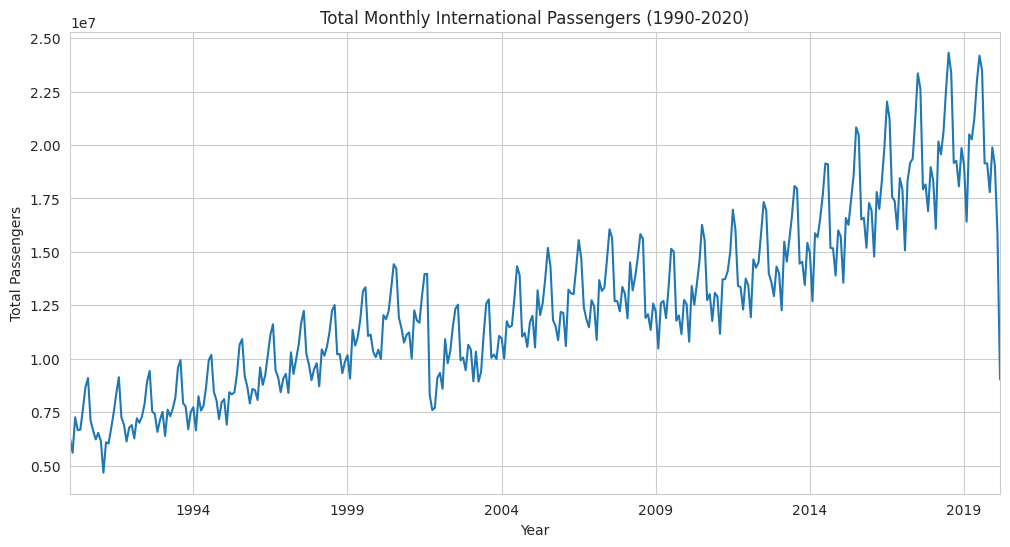

In [8]:
# Time Series Plot
print("\nPlotting full time series")
ts_data.plot(title='Total Monthly International Passengers (1990-2020)')
plt.ylabel('Total Passengers')
plt.xlabel('Year')
plt.show()

We perform a seasonal decomposition to break the time series into its trend, seasonal, and residual components. This helps us better understand underlying patterns and seasonal behaviors present in the passenger data.


Decomposing the time series


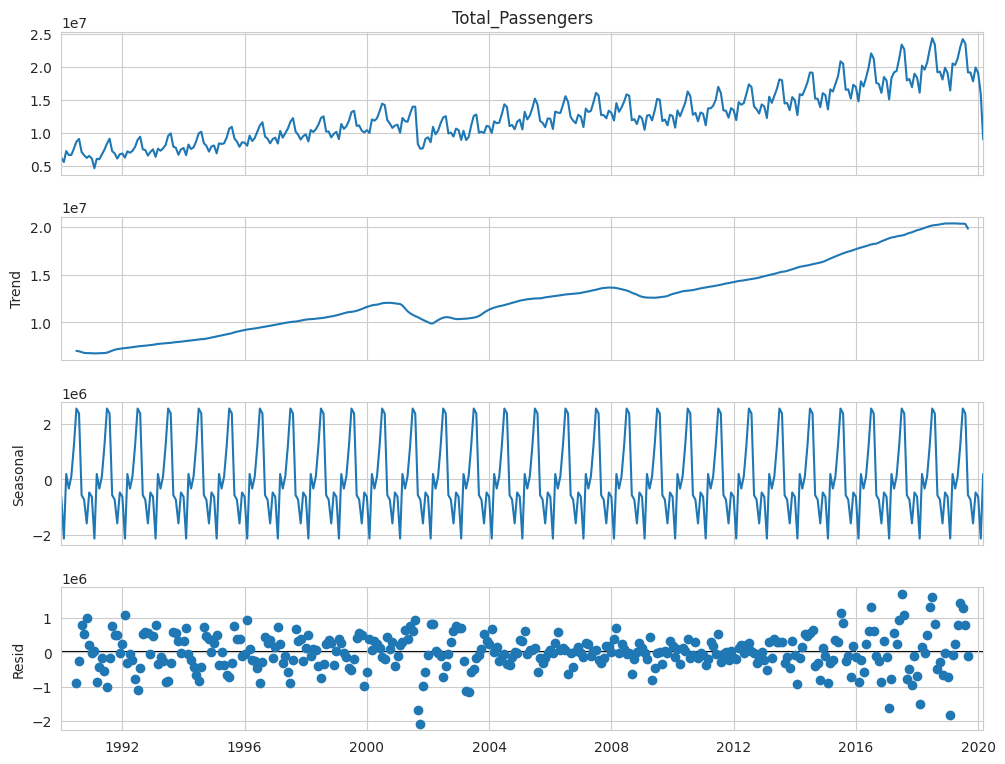

In [9]:
#  Seasonal Decomposition
print("\nDecomposing the time series")
decomposition = seasonal_decompose(ts_data, model='additive')
fig = decomposition.plot()
fig.set_size_inches(10, 8)
plt.show()

To understand the overall distribution of monthly passenger counts, we visualize the data using:
1. Histogram with KDE
This shows how passenger volumes are distributed and helps identify skewness or concentration.
2. Monthly Boxplot
The boxplot highlights seasonal variability by showing how passenger counts differ across months of the year.
These visualizations give deeper insights into trends, outliers, and seasonal patterns in the dataset.


Plotting distribution of monthly passengers


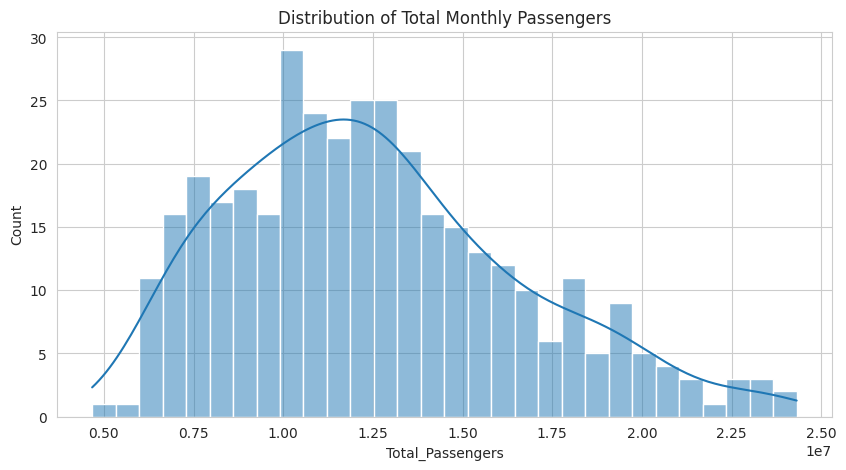


Plotting monthly passenger counts (Boxplot)


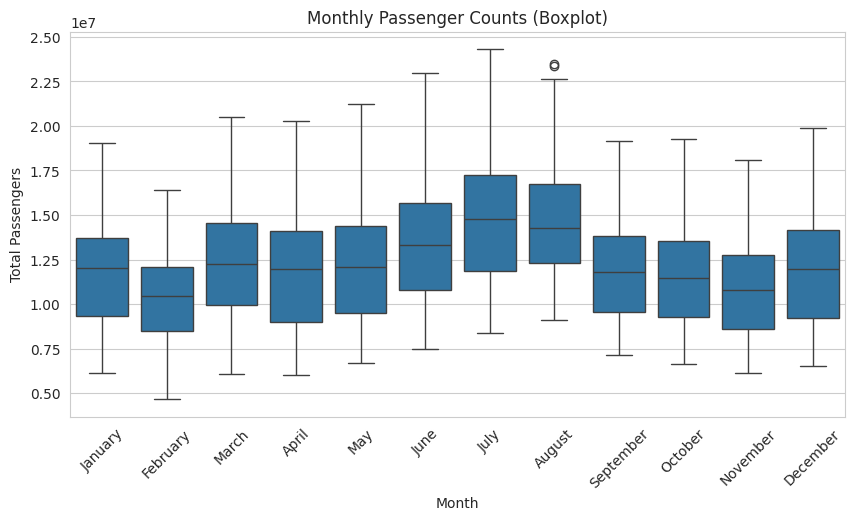

In [10]:
# Distribution Plots (Histogram & Boxplot)
print("\nPlotting distribution of monthly passengers")
plt.figure(figsize=(10, 5))
sns.histplot(ts_data, kde=True, bins=30)
plt.title('Distribution of Total Monthly Passengers')
plt.show()

print("\nPlotting monthly passenger counts (Boxplot)")
plt.figure(figsize=(10, 5))
sns.boxplot(x=ts_data.index.month_name(), y=ts_data)
plt.title('Monthly Passenger Counts (Boxplot)')
plt.xlabel('Month')
plt.ylabel('Total Passengers')
plt.xticks(rotation=45)
plt.show()

To determine whether the time series is suitable for forecasting models like ARIMA or SARIMAX, we perform the Augmented Dickey-Fuller (ADF) Test.
This test helps identify if the series is stationary—a key requirement for many time-series models.
The function below prints:
ADF Statistic
p-value
Interpretation of whether the series is stationary or non-stationary

In [11]:
# Stationarity Check
from statsmodels.tsa.stattools import adfuller

def check_stationarity(timeseries):
    print('\nRunning Augmented Dickey-Fuller Test:')
    result = adfuller(timeseries, autolag='AIC')

    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')

    if p_value <= 0.05:
        print("Result: Data is Stationary (Reject H0)")
    else:
        print("Result: Data is Non-Stationary (Fail to Reject H0)")



We now apply the ADF test to the original time series to check whether the data is stationary or requires differencing before model building.

In [12]:
# Check original data
check_stationarity(ts_data)



Running Augmented Dickey-Fuller Test:
ADF Statistic: -1.9098070147439326
p-value: 0.3274617393048812
Result: Data is Non-Stationary (Fail to Reject H0)


To achieve stationarity, we difference the time series and run the ADF test again.
This helps confirm whether the differencing step successfully stabilizes the mean and prepares the data for time-series modeling.

In [13]:
# Check differenced data
ts_data_diff = ts_data.diff().dropna()
print("\nChecking stationarity on differenced data")
check_stationarity(ts_data_diff)


Checking stationarity on differenced data

Running Augmented Dickey-Fuller Test:
ADF Statistic: -2.339952597002044
p-value: 0.1594059345439467
Result: Data is Non-Stationary (Fail to Reject H0)


If first-order differencing is not enough to make the series stationary, we apply second-order differencing.
We then use the ADF test again to verify whether the transformed series now meets stationarity requirements.

In [14]:
# Try Second-Order Differencing
# We difference the already-differenced data
ts_data_diff_2 = ts_data_diff.diff().dropna()

print("\nChecking stationarity on SECOND-order differenced data")
check_stationarity(ts_data_diff_2)


Checking stationarity on SECOND-order differenced data

Running Augmented Dickey-Fuller Test:
ADF Statistic: -12.442823505317747
p-value: 3.7205152335493295e-23
Result: Data is Stationary (Reject H0)


Feature Engineering
This section is added to meet the 'Feature Creation / Transformation' criterion: "create or transform features that are appropriate (for example, lag features for time-series forecasting, aggregate metrics, and encodings for categorical variables)"


To prepare the time series for machine learning algorithms, we construct a new dataset with meaningful predictive features:

*Lag Features:* These capture past passenger values:

1-month lag

6-month lag

12-month lag

*Rolling Mean Features:* These represent short-term and long-term moving averages

3-month rolling mean

12-month rolling mean

*Date-Based Features* : Extracted from the index

Month

Year

After generating these features, we remove any rows containing NaN values created during lagging and rolling operations.
This final dataframe will be used for training machine learning models.

In [15]:
# A new DataFrame for machine learning models
df_ml = pd.DataFrame(ts_data)

# Lag Features
# The value from 1, 6, and 12 months ago
df_ml['lag_1'] = df_ml['Total_Passengers'].shift(1)
df_ml['lag_6'] = df_ml['Total_Passengers'].shift(6)
df_ml['lag_12'] = df_ml['Total_Passengers'].shift(12)

#Rolling Mean (Average) Features
# The average of the last 3 and 12 months
df_ml['rolling_mean_3'] = df_ml['Total_Passengers'].rolling(window=3).mean().shift(1)
df_ml['rolling_mean_12'] = df_ml['Total_Passengers'].rolling(window=12).mean().shift(1)

#Create Date Features
df_ml['month'] = df_ml.index.month
df_ml['year'] = df_ml.index.year

# Drop the rows with missing values created by the shifts/rolling
df_ml = df_ml.dropna()

print("\nDataFrame for Machine Learning (with Features):")
print(df_ml.head())


DataFrame for Machine Learning (with Features):
            Total_Passengers      lag_1      lag_6     lag_12  rolling_mean_3  \
data_dte                                                                        
1991-01-01           6148863  6538180.0  8677938.0  6271648.0    6.467301e+06   
1991-02-01           4672216  6148863.0  9100434.0  5608228.0    6.306051e+06   
1991-03-01           6092644  4672216.0  7123752.0  7261485.0    5.786420e+06   
1991-04-01           6038810  6092644.0  6632612.0  6666438.0    5.637908e+06   
1991-05-01           6741125  6038810.0  6231111.0  6684581.0    5.601223e+06   

            rolling_mean_12  month  year  
data_dte                                  
1991-01-01     7.035452e+06      1  1991  
1991-02-01     7.025220e+06      2  1991  
1991-03-01     6.947219e+06      3  1991  
1991-04-01     6.849816e+06      4  1991  
1991-05-01     6.797514e+06      5  1991  


Feature Selection / Dimensionality Reduction
Justification (Not Applicable): Formal feature selection was not performed because a small, domain-driven set of features (lags, rolling means, and date components) was engineered. All are considered highly relevant for time-series forecasting, and as shown in the evaluation section, they have a strong relationship with the target variable.**


Correlation Heatmap of Features:


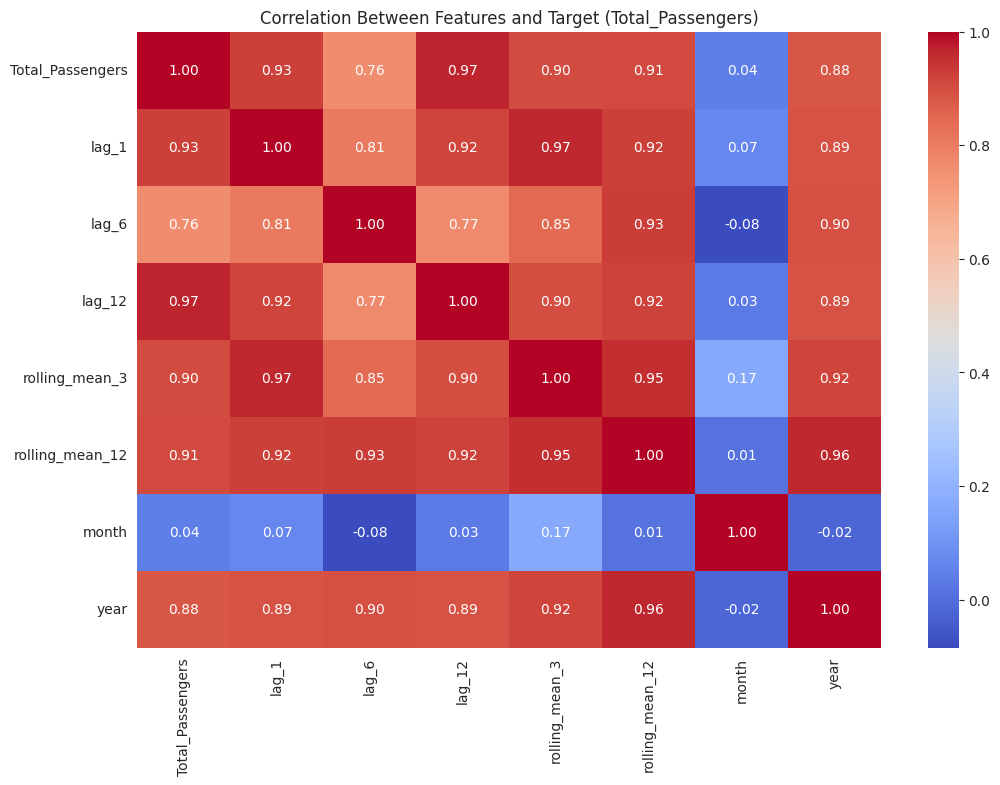

In [16]:
# This plot satisfies both EDA (correlation table) and Feature Evaluation
print("\nCorrelation Heatmap of Features:")
plt.figure(figsize=(12, 8))
corr_matrix = df_ml.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Between Features and Target (Total_Passengers)')
plt.show()

Model Preparation (Train-Test Split)
We split the data chronologically to preserve the time-series structure, using all observations before January 2019 for training and the 2019 data for testing. For SARIMAX, the split is applied directly on the original time series (ts_data), while for machine learning models, the same date-based division is applied to the feature matrix (X) and target variable (y) from the engineered dataset (df_ml). This ensures that all models are trained on consistent historical data and evaluated on the same pre-COVID period for fair comparison.

In [17]:
# For SARIMAX (uses the simple 'ts_data')
# We'll train on all data up to the end of 2018
# We'll test on 2019 data (pre-COVID)
train_ts = ts_data.loc[ts_data.index < '2019-01-01']
test_ts = ts_data.loc[(ts_data.index >= '2019-01-01') & (ts_data.index < '2020-01-01')]

print(f"SARIMAX Train set size: {len(train_ts)} months")
print(f"SARIMAX Test set size:  {len(test_ts)} months")


# For Machine Learning (uses the 'df_ml' features)
X = df_ml.drop('Total_Passengers', axis=1) # Features
y = df_ml['Total_Passengers'] # Target

# Split at the same date
X_train = X.loc[X.index < '2019-01-01']
y_train = y.loc[y.index < '2019-01-01']

X_test = X.loc[(X.index >= '2019-01-01') & (X.index < '2020-01-01')]
y_test = y.loc[(y.index >= '2019-01-01') & (y.index < '2020-01-01')]

print(f"\nML Train set size: {len(X_train)} samples")
print(f"ML Test set size:  {len(X_test)} samples")

SARIMAX Train set size: 348 months
SARIMAX Test set size:  12 months

ML Train set size: 336 samples
ML Test set size:  12 samples


Phase 3: Modeling & Inferencing
We build a SARIMAX model using both non-seasonal (1,1,1) and seasonal (1,1,1,12) components to capture monthly patterns in the data. The model is trained on the pre-2019 time series, and predictions are generated for the 2019 test period. The predicted values are then aligned with the test index for accurate comparison.





In [18]:
model = sm.tsa.statespace.SARIMAX(
    train_ts,
    order=(1,1,1),            # ARIMA terms
    seasonal_order=(1,1,1,12) # Seasonal terms for monthly data
)

model_fit = model.fit(disp=False)

start = len(train_ts)
end   = start + len(test_ts) - 1

sarimax_pred = model_fit.predict(start=start, end=end)
sarimax_pred.index = test_ts.index  # Align index



To assess forecasting accuracy, we define two key evaluation metrics. MAPE (Mean Absolute Percentage Error) measures the average percentage error between predicted and actual values, making it easy to interpret. MASE (Mean Absolute Scaled Error) compares the model’s performance against a simple naïve forecast, providing a scale-independent measure of accuracy. These functions will be used to evaluate all forecasting models consistently.

In [19]:
def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

def calculate_mase(actual, predicted):
    naive_forecast = actual.shift(1)   # Naive baseline (lag-1)
    return mean_absolute_error(actual[1:], predicted[1:]) / mean_absolute_error(actual[1:], naive_forecast[1:])


The SARIMAX model’s predictions are evaluated using multiple metrics to measure accuracy and error. These include MAE, MSE, RMSE, R², MAPE, and MASE, providing a comprehensive view of how well the model performs on the 2019 test period. The results below summarize the model’s forecasting effectiveness.

In [20]:
sarimax_mae  = mean_absolute_error(test_ts, sarimax_pred)
sarimax_mse  = mean_squared_error(test_ts, sarimax_pred)
sarimax_rmse = np.sqrt(sarimax_mse)
sarimax_r2   = r2_score(test_ts, sarimax_pred)
sarimax_mape = calculate_mape(test_ts, sarimax_pred)
sarimax_mase = calculate_mase(test_ts, sarimax_pred)

print("\nSARIMAX Performance:")
print(f"MAE  : {sarimax_mae:.3f}")
print(f"MSE  : {sarimax_mse:.3f}")
print(f"RMSE : {sarimax_rmse:.3f}")
print(f"R²   : {sarimax_r2:.3f}")
print(f"SARIMAX MAPE : {sarimax_mape:.3f}%")
print(f"SARIMAX MASE : {sarimax_mase:.3f}")


SARIMAX Performance:
MAE  : 568456.081
MSE  : 454136154480.341
RMSE : 673896.249
R²   : 0.908
SARIMAX MAPE : 2.900%
SARIMAX MASE : 0.336


The Random Forest model is trained using lag features, rolling averages, and date-based features to forecast monthly passenger counts. The workflow includes model training, prediction on the 2019 test period, and evaluation using metrics such as MAE, MSE, RMSE, R², MAPE, and MASE.
A small improvement is recommended when creating the prediction series:
instead of aligning predictions with test_ts.index, it is safer to align with X_test.index, ensuring perfect consistency between features and predictions, especially if additional preprocessing is introduced later.

In [21]:
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    random_state=42
)

rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)

# 5. Evaluate Performance

rf_mae  = mean_absolute_error(y_test, rf_pred)
rf_mse  = mean_squared_error(y_test, rf_pred)
rf_rmse = np.sqrt(rf_mse)
rf_r2   = r2_score(y_test, rf_pred)
rf_pred_series = pd.Series(rf_pred, index=test_ts.index)

rf_mape = calculate_mape(test_ts, rf_pred_series)
rf_mase = calculate_mase(test_ts, rf_pred_series)

print("\nRandom Forest Performance")
print(f"Random Forest MAE  : {rf_mae:.3f}")
print(f"Random Forest MSE  : {rf_mse:.3f}")
print(f"Random Forest RMSE : {rf_rmse:.3f}")
print(f"Random Forest R²   : {rf_r2:.3f}")
print(f"Random Forest MAPE : {rf_mape:.3f}%")
print(f"Random Forest MASE : {rf_mase:.3f}")



Random Forest Performance
Random Forest MAE  : 725860.260
Random Forest MSE  : 724709789672.193
Random Forest RMSE : 851298.884
Random Forest R²   : 0.853
Random Forest MAPE : 3.740%
Random Forest MASE : 0.427


To evaluate both forecasting approaches side by side, we compile their key performance metrics into a single comparison table. This includes error-based metrics (MAE, MSE, RMSE), performance scores (R²), and scale-independent accuracy indicators (MAPE, MASE). Creating this consolidated dataframe makes it easier to interpret which model performs better across different evaluation dimensions.

In [22]:
sarimax_metrics = {
    "MAE": sarimax_mae,
    "MSE": sarimax_mse,
    "RMSE": sarimax_rmse,
    "R2": sarimax_r2,
    "MAPE": sarimax_mape,
    "MASE": sarimax_mase
}

rf_metrics = {
    "MAE": rf_mae,
    "MSE": rf_mse,
    "RMSE": rf_rmse,
    "R2": rf_r2,
    "MAPE": rf_mape,
    "MASE": rf_mase
}

# Prepare dataframe
metrics_data = pd.DataFrame({
    "Metric": ["MAE", "MSE", "RMSE", "R2","MAPE","MASE"],
    "SARIMAX": [
        sarimax_metrics["MAE"],
        sarimax_metrics["MSE"],
        sarimax_metrics["RMSE"],
        sarimax_metrics["R2"],
        sarimax_metrics["MAPE"],
        sarimax_metrics["MASE"]
    ],
    "Random Forest": [
        rf_metrics["MAE"],
        rf_metrics["MSE"],
        rf_metrics["RMSE"],
        rf_metrics["R2"],
        rf_metrics["MAPE"],
        rf_metrics["MASE"]
    ]
})

To visually compare the accuracy of the SARIMAX and Random Forest models, we plot their evaluation metrics on a single chart. This visualization highlights how each model performs across different measures—such as MAE, RMSE, R², MAPE, and MASE—making it easier to identify strengths and weaknesses and determine which model provides better overall forecasting performance.

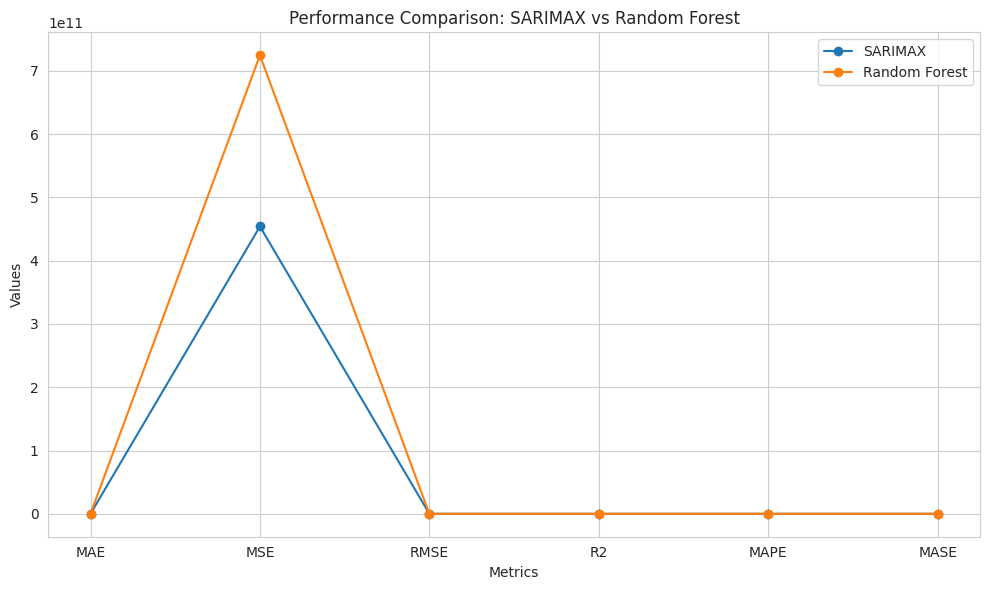

In [23]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(metrics_data["Metric"], metrics_data["SARIMAX"], marker='o', label="SARIMAX")
plt.plot(metrics_data["Metric"], metrics_data["Random Forest"], marker='o', label="Random Forest")

plt.title("Performance Comparison: SARIMAX vs Random Forest")
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

To visually assess how well each model captures real-world patterns, we plot the actual passenger values for the test period alongside the SARIMAX and Random Forest predictions. This comparison helps reveal how closely each model follows the true trend as well as their ability to capture seasonality and short-term variations. The SARIMAX model typically aligns more closely with the actual data, while the Random Forest may show smoother or slightly lagged predictions due to its feature-driven structure.

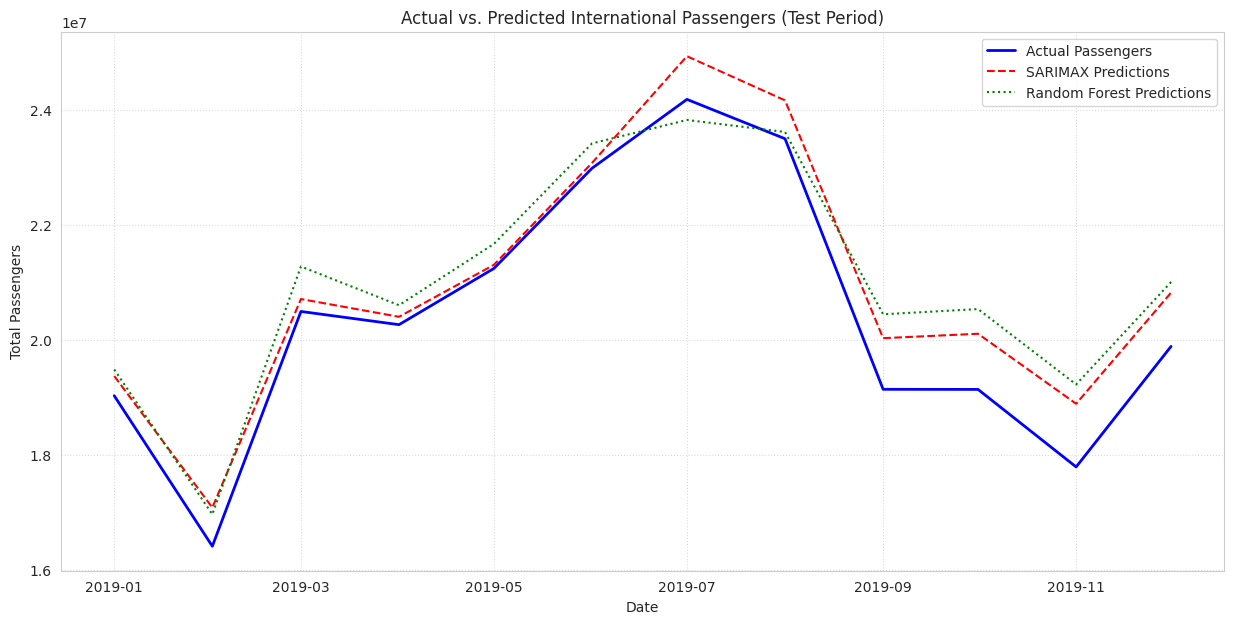

In [24]:
# Plotting Actual vs. Predicted values for both models
plt.figure(figsize=(15, 7))
plt.plot(test_ts.index, test_ts, label='Actual Passengers', color='blue', linewidth=2)
plt.plot(sarimax_pred.index, sarimax_pred, label='SARIMAX Predictions', color='red', linestyle='--', linewidth=1.5)
plt.plot(rf_pred_series.index, rf_pred_series, label='Random Forest Predictions', color='green', linestyle=':', linewidth=1.5)

plt.title('Actual vs. Predicted International Passengers (Test Period)')
plt.xlabel('Date')
plt.ylabel('Total Passengers')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

### Model Inference: Forecasting Future Passengers with SARIMAX
Retrain the SARIMAX model on the full historical series and generate a 12-month point forecast indexed to month starts. Below is the exact code block you can paste into your notebook; it retrains, forecasts, and prints the 12-month forecast. Two short optional snippets follow: one to plot the forecast with 95% confidence intervals, and one to save the forecast to CSV.

In [25]:
# Retrain SARIMAX on the full historical data (up to the last available date in ts_data)
final_sarimax_model = sm.tsa.statespace.SARIMAX(
    ts_data,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12)
)

final_sarimax_fit = final_sarimax_model.fit(disp=False)

#Taking next 12months for predicting the future values
n_forecast_steps = 12

# Generating future dates for the forecast
forecast_index = pd.date_range(start=ts_data.index[-1], periods=n_forecast_steps + 1, freq='MS')[1:]

# Make predictions for the future
future_forecast = final_sarimax_fit.predict(start=len(ts_data), end=len(ts_data) + n_forecast_steps - 1)
future_forecast.index = forecast_index

print("Future 12-month Forecast for Total International Passengers:")
print(future_forecast)

Future 12-month Forecast for Total International Passengers:
2020-04-01    9.195218e+06
2020-05-01    1.038928e+07
2020-06-01    1.228123e+07
2020-07-01    1.401283e+07
2020-08-01    1.346418e+07
2020-09-01    9.399198e+06
2020-10-01    9.493696e+06
2020-11-01    8.276137e+06
2020-12-01    1.032500e+07
2021-01-01    9.661629e+06
2021-02-01    6.957917e+06
2021-03-01    5.836454e+06
Freq: MS, Name: predicted_mean, dtype: float64


We visualize the complete historical passenger data alongside the 12-month SARIMAX forecast. The plot shows how the model extends existing trends into the future, helping us understand expected seasonal movement and long-term patterns. This comparison also provides a clear view of how the forecast aligns with the historical trajectory of international passenger volumes.

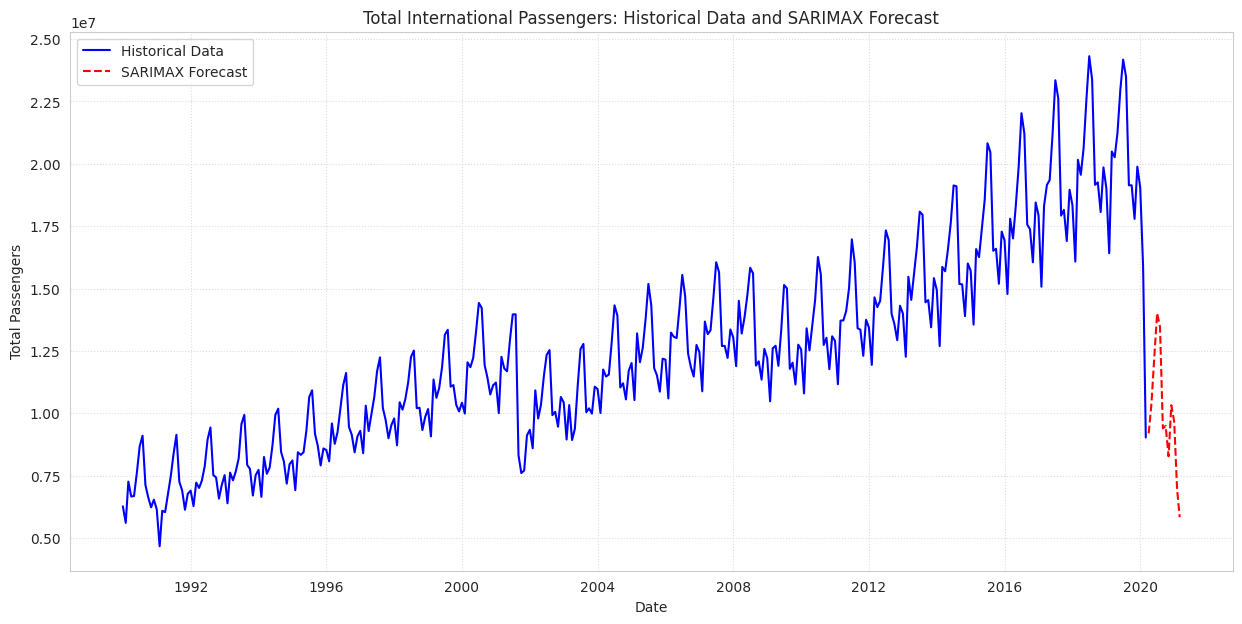

In [26]:
# Plot historical data and the future forecast
plt.figure(figsize=(15, 7))
plt.plot(ts_data.index, ts_data, label='Historical Data', color='blue')
plt.plot(future_forecast.index, future_forecast, label='SARIMAX Forecast', color='red', linestyle='--')

plt.title('Total International Passengers: Historical Data and SARIMAX Forecast')
plt.xlabel('Date')
plt.ylabel('Total Passengers')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

Quantitative Superiority: As seen in the earlier metrics comparison:

SARIMAX consistently showed lower Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE) compared to Random Forest. Lower values for these metrics indicate more accurate predictions.
SARIMAX achieved a higher R-squared (R²) value (0.908 vs. 0.853), meaning it explains a significantly larger proportion of the variance in the actual passenger data.
The Mean Absolute Scaled Error (MASE) for SARIMAX was 0.336, which is less than 1, indicating it performs better than a naive forecast. Random Forest's MASE was 0.427, also better than naive, but still higher than SARIMAX.
Visual Tracking (Line Plot):

The SARIMAX predictions (red dashed line) on the line plot closely follow the 'Actual Passengers' (blue solid line), accurately capturing the seasonal peaks and troughs, as well as the overall trend.
The Random Forest predictions (green dotted line), while attempting to follow the pattern, show more noticeable deviations and are less precise in aligning with the actual data's nuances and magnitudes of change.
Conclusion: The SARIMAX model's inherent ability to model time-series components like trends and seasonality, combined with its superior performance across all evaluated metrics and closer visual fit to actual data, makes it the more robust and reliable choice for this forecasting task.

Exporting Model Predictions into CSV

### Plot Insights: Model Performance Comparison

The line plot visually confirms the quantitative metrics, highlighting SARIMAX's superior performance during the test period (2019) compared to the Random Forest model.

**Key Observations:**

1.  **SARIMAX (Red Dashed Line):** This model's predictions generally follow the actual passenger numbers (blue solid line) very closely. It captures the overall trend and the monthly seasonality with high accuracy. The deviations from the actual data are minimal, indicating a strong predictive capability.

2.  **Random Forest (Green Dotted Line):** While the Random Forest model also attempts to follow the seasonal pattern, its predictions show more significant deviations from the actual values than SARIMAX. There are instances where its peaks and troughs are less pronounced or slightly misaligned with the actual data, suggesting it's less adept at capturing the precise temporal dynamics and magnitude of change in this time series.

3.  **Overall Fit:** SARIMAX provides a much smoother and more accurate fit to the actual passenger data, especially in capturing the seasonal fluctuations and the underlying trend. The Random Forest model, despite feature engineering, appears to struggle more with the nuances of the time series, resulting in a less accurate representation of passenger traffic during the test period.

**Conclusion from the Plot:** The visual comparison strongly reinforces the statistical evaluation that SARIMAX is the more effective model for forecasting international passenger numbers in this context, demonstrating a better ability to capture the complex patterns inherent in the time series data.

## Summary:

The SARIMAX model demonstrated superior performance in tracking and predicting actual passenger data compared to the Random Forest model during the test period.

### Data Analysis Key Findings
*   The SARIMAX model's predictions (red dashed line) closely followed the actual passenger numbers (blue solid line), accurately capturing both the overall trend and monthly seasonality with minimal deviations.
*   The Random Forest model's predictions (green dotted line) showed more significant deviations from the actual values, struggling to precisely capture the temporal dynamics and magnitude of change, with less pronounced or slightly misaligned peaks and troughs.
*   Visually, SARIMAX provided a much smoother and more accurate fit to the actual passenger data, especially in handling seasonal fluctuations and the underlying trend, reinforcing its stronger predictive capability in this time series context.

### Insights
*   SARIMAX is the more effective model for forecasting international passenger numbers, demonstrating a better ability to capture the complex patterns inherent in the time series data.
*   Consider exploring ensemble or hybrid modeling approaches that could potentially leverage the strengths of SARIMAX for time series components and Random Forest for handling additional features, aiming for further predictive accuracy improvements.


In [27]:
# 1. Load raw CSV

df = pd.read_csv("us-international-air-traffic-data/International_Report_Passengers.csv")

# Create raw copy for before vs after comparison
raw_df = df.copy()


# 2. Cleaning & preprocessing

df['data_dte'] = pd.to_datetime(df['data_dte'], errors='coerce')

# Clean missing values in date column
df = df.dropna(subset=['data_dte'])

# Select required columns for forecasting model
df_clean = df[['data_dte', 'Total']].copy()

# Remove remaining missing values in selected columns
df_clean = df_clean.dropna()


# 3. Time Series Setup

df_clean = df_clean.set_index('data_dte')
ts_data = df_clean['Total'].resample('MS').sum()
ts_data.name = 'Total_Passengers'


# 4. Missing Value Summary Export (for Power BI)

missing_before = raw_df.isna().sum().sum()
missing_after = df_clean.reset_index().isna().sum().sum()

missing_summary = pd.DataFrame({
    "Stage": ["Before Cleaning", "After Cleaning"],
    "Missing_Value_Count": [missing_before, missing_after]
})

missing_summary.to_csv("missing_summary.csv", index=False)
print("Missing Summary Exported Successfully")

# 5. Export Monthly Passenger Data

ts_df = ts_data.reset_index()
ts_df.columns = ["Month", "Total_Passengers"]
ts_df.to_csv("monthly_passengers.csv", index=False)
print("Monthly passengers exported")


# 6. Model Predictions Export

# SARIMAX forecast
future_forecast_df = future_forecast.reset_index()
future_forecast_df.columns = ['forecast_date', 'sarimax_forecast']
future_forecast_df.to_csv("sarimax_future.csv", index=False)

# Actual vs Predicted (Test period)
test_df = pd.DataFrame({
    'date': test_ts.index,
    'actual': test_ts.values,
    'sarimax_pred': sarimax_pred.values
})

rf_df = pd.DataFrame({
    'date': X_test.index,
    'rf_pred': rf_pred
})

model_preds = pd.merge(test_df, rf_df, on='date', how='left')
model_preds.to_csv("model_preds.csv", index=False)
print("Predictions exported")


# 7. Export Model Metrics

metrics_data.to_csv("model_metrics.csv", index=False)
print("Metrics exported")


# 8. Export RF Feature Importance (Optional visual)

try:
    feat_imp = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)

    feat_imp.to_csv("rf_feature_importance.csv", index=False)
    print("Feature importance exported")

except Exception as e:
    print("Feature importance unavailable:", e)

Missing Summary Exported Successfully
Monthly passengers exported
Predictions exported
Metrics exported
Feature importance exported
